# General examples of los calculations

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sympy.printing.pretty.pretty_symbology import line_width

## Computational burden

The computational burden is the slope of the simulation time vs execution time.

In general, the simulation time is equally spaced according to some step size $\delta t$.

The execution time, instead, might vary across different runs due to underlying hardware, software, etc.

In [24]:
# Simulation time
sim_time = np.linspace(0, 60, 100)

# Execution time realizations
n_real = 50
exec_time = np.zeros((n_real, len(sim_time)))
for i in range(n_real):
    for j in range(1, len(sim_time)):
        increment = np.random.uniform(0.5, 2.0)
        exec_time[i, j] = exec_time[i, j-1] + increment

In [25]:
from greyboxmodels.voi.metrics.computational_load import computational_load

# Computational load
slopes = [computational_load(sim_time, exec_time[i, :]) for i in range(n_real)]
comp_load = np.mean(slopes)

eff_curve = comp_load * sim_time

(0.0, 150.0)

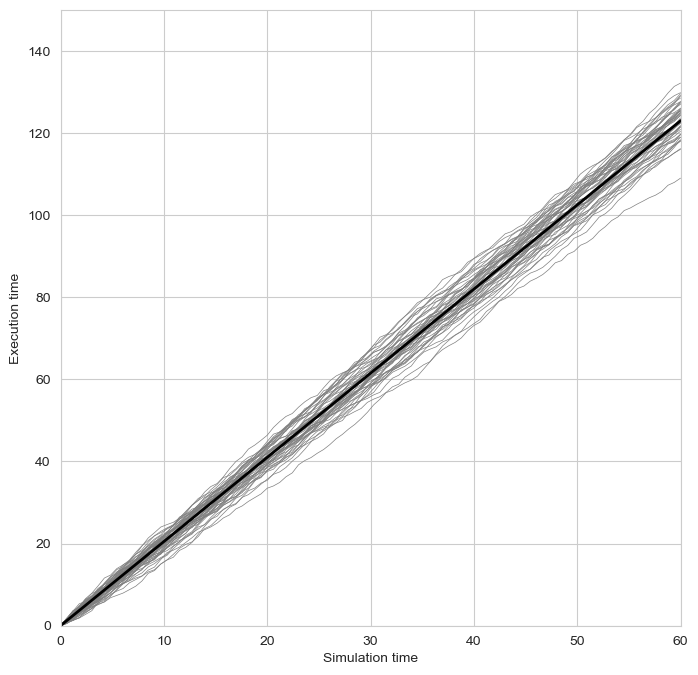

In [27]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for i in range(n_real):
    ax.plot(sim_time, exec_time[i, :], linewidth=0.5, color='gray')

ax.plot(sim_time, eff_curve, linewidth=2, color='black')

ax.set_xlabel('Simulation time')
ax.set_ylabel('Execution time')
ax.set_xlim([0, 60])
ax.set_ylim([0, 150])